In [3]:
# @title Check if MuJoCo installation was successful

# Set up GPU rendering.
import distutils.util
import os
import subprocess

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
# NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
# if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
#   with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
#     f.write("""{
#     "file_format_version" : "1.0.0",
#     "ICD" : {
#         "library_path" : "libEGL_nvidia.so.0"
#     }
# }
# """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print("Setting environment variable to use GPU rendering:")
# %env MUJOCO_GL=glx

# Check if installation was succesful.
try:
    print("Checking that the installation succeeded:")
    import mujoco

    mujoco.MjModel.from_xml_string("<mujoco/>")
except Exception as e:
    raise e from RuntimeError(
        "Something went wrong during installation. Check the shell output above "
        "for more information.\n"
        "If using a hosted Colab runtime, make sure you enable GPU acceleration "
        'by going to the Runtime menu and selecting "Choose runtime type".'
    )

print("Installation successful.")

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output

clear_output()

In [4]:
# @title Import MuJoCo, MJX, and Brax

import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.8"  # 0.9 causes too much lag.
from datetime import datetime
import functools

# Math
import jax.numpy as jp
import numpy as np
import jax
from jax import config  # Analytical gradients work much better with double precision.

config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)
config.update("jax_default_matmul_precision", "high")
from brax import math

# Sim
import mujoco
import mujoco.mjx as mjx

# Brax
from brax import envs
from brax.base import Motion, Transform
from brax.io import mjcf
from brax.envs.base import PipelineEnv, State
from brax.mjx.pipeline import _reformat_contact
from brax.training.acme import running_statistics
from brax.io import model

# Algorithms
from brax.training.agents.apg import train as apg
from brax.training.agents.apg import networks as apg_networks
from brax.training.agents.ppo import train as ppo

# Supporting
from etils import epath
import mediapy as media
import matplotlib.pyplot as plt
from ml_collections import config_dict
from typing import Any, Dict

""

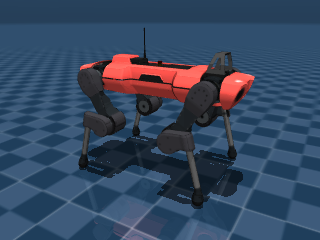

In [5]:
xml_path = epath.Path("mujoco_menagerie/anybotics_anymal_c/scene_mjx.xml").as_posix()

mj_model = mujoco.MjModel.from_xml_path(xml_path)

if "renderer" not in dir():
    renderer = mujoco.Renderer(mj_model)

init_q = mj_model.keyframe("standing").qpos

mj_data = mujoco.MjData(mj_model)
mj_data.qpos = init_q
mujoco.mj_forward(mj_model, mj_data)

renderer.update_scene(mj_data)
media.show_image(renderer.render())

In [6]:
# Rendering Rollouts
def render_rollout(
    reset_fn, step_fn, inference_fn, env, n_steps=200, camera=None, seed=0
):
    rng = jax.random.key(seed)
    render_every = 3
    state = reset_fn(rng)
    rollout = [state.pipeline_state]

    for i in range(n_steps):
        act_rng, rng = jax.random.split(rng)
        ctrl, _ = inference_fn(state.obs, act_rng)
        state = step_fn(state, ctrl)
        if i % render_every == 0:
            rollout.append(state.pipeline_state)

    media.show_video(
        env.render(rollout, camera=camera),
        fps=1.0 / (env.dt * render_every),
        codec="gif",
    )

In [7]:
def cos_wave(t, step_period, scale):
    _cos_wave = -jp.cos(((2 * jp.pi) / step_period) * t)
    return _cos_wave * (scale / 2) + (scale / 2)


def dcos_wave(t, step_period, scale):
    """
    Derivative of the cos wave, for reference velocity
    """
    return ((scale * jp.pi) / step_period) * jp.sin(((2 * jp.pi) / step_period) * t)


def make_kinematic_ref(sinusoid, step_k, scale=0.3, dt=1 / 50):
    """
    Makes trotting kinematics for the 12 leg joints.
    step_k is the number of timesteps it takes to raise and lower a given foot.
    A gait cycle is 2 * step_k * dt seconds long.
    """

    _steps = jp.arange(step_k)
    step_period = step_k * dt
    t = _steps * dt

    wave = sinusoid(t, step_period, scale)
    # Commands for one step of an active front leg
    fleg_cmd_block = jp.concatenate(
        [jp.zeros((step_k, 1)), wave.reshape(step_k, 1), -2 * wave.reshape(step_k, 1)],
        axis=1,
    )
    # Our standing config reverses front and hind legs
    h_leg_cmd_bloc = -1 * fleg_cmd_block

    block1 = jp.concatenate(
        [jp.zeros((step_k, 3)), fleg_cmd_block, h_leg_cmd_bloc, jp.zeros((step_k, 3))],
        axis=1,
    )

    block2 = jp.concatenate(
        [fleg_cmd_block, jp.zeros((step_k, 3)), jp.zeros((step_k, 3)), h_leg_cmd_bloc],
        axis=1,
    )
    # In one step cycle, both pairs of active legs have inactive and active phases
    step_cycle = jp.concatenate([block1, block2], axis=0)
    return step_cycle

""

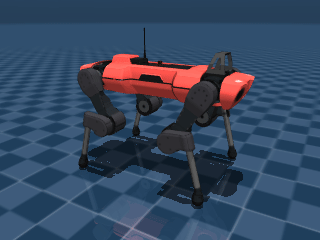

In [8]:
poses = make_kinematic_ref(cos_wave, step_k=25)

frames = []
init_q = mj_model.keyframe("standing").qpos
mj_data.qpos = init_q
default_ap = init_q[7:]

for i in range(len(poses)):
    mj_data.qpos[7:] = poses[i] + default_ap
    mujoco.mj_forward(mj_model, mj_data)
    renderer.update_scene(mj_data)
    frames.append(renderer.render())

media.show_video(frames, fps=50, codec="gif")

In [9]:
def get_config():
    def get_default_rewards_config():
        default_config = config_dict.ConfigDict(
            dict(
                scales=config_dict.ConfigDict(
                    dict(
                        min_reference_tracking=-2.5 * 3e-3,  # to equalize the magnitude
                        reference_tracking=-1.0,
                        feet_height=-1.0,
                    )
                )
            )
        )
        return default_config

    default_config = config_dict.ConfigDict(
        dict(
            rewards=get_default_rewards_config(),
        )
    )

    return default_config


# Math functions from (https://github.com/jiawei-ren/diffmimic)
def quaternion_to_matrix(quaternions):
    r, i, j, k = (
        quaternions[..., 0],
        quaternions[..., 1],
        quaternions[..., 2],
        quaternions[..., 3],
    )
    two_s = 2.0 / (quaternions * quaternions).sum(-1)

    o = jp.stack(
        (
            1 - two_s * (j * j + k * k),
            two_s * (i * j - k * r),
            two_s * (i * k + j * r),
            two_s * (i * j + k * r),
            1 - two_s * (i * i + k * k),
            two_s * (j * k - i * r),
            two_s * (i * k - j * r),
            two_s * (j * k + i * r),
            1 - two_s * (i * i + j * j),
        ),
        -1,
    )
    return o.reshape(quaternions.shape[:-1] + (3, 3))


def matrix_to_rotation_6d(matrix):
    batch_dim = matrix.shape[:-2]
    return matrix[..., :2, :].reshape(batch_dim + (6,))


def quaternion_to_rotation_6d(quaternion):
    return matrix_to_rotation_6d(quaternion_to_matrix(quaternion))


class TrotAnymal(PipelineEnv):
    def __init__(
        self,
        termination_height: float = 0.25,
        **kwargs,
    ):
        step_k = kwargs.pop("step_k", 25)

        physics_steps_per_control_step = 10
        kwargs["n_frames"] = kwargs.get("n_frames", physics_steps_per_control_step)

        mj_model = mujoco.MjModel.from_xml_path(xml_path)
        kp = 230
        mj_model.actuator_gainprm[:, 0] = kp
        mj_model.actuator_biasprm[:, 1] = -kp

        sys = mjcf.load_model(mj_model)

        super().__init__(sys=sys, **kwargs)

        self.termination_height = termination_height

        self._init_q = mj_model.keyframe("standing").qpos

        self.err_threshold = 0.4  # diffmimic; value from paper.

        self._default_ap_pose = mj_model.keyframe("standing").qpos[7:]
        self.reward_config = get_config()

        self.action_loc = self._default_ap_pose
        self.action_scale = jp.array([0.2, 0.8, 0.8] * 4)

        self.feet_inds = jp.array([21, 28, 35, 42])  # LF, RF, LH, RH

        #### Imitation reference
        kinematic_ref_qpos = make_kinematic_ref(cos_wave, step_k, scale=0.3, dt=self.dt)
        kinematic_ref_qvel = make_kinematic_ref(
            dcos_wave, step_k, scale=0.3, dt=self.dt
        )

        self.l_cycle = jp.array(kinematic_ref_qpos.shape[0])

        # Expand to entire state space.

        kinematic_ref_qpos += self._default_ap_pose
        ref_qs = np.tile(self._init_q.reshape(1, 19), (self.l_cycle, 1))
        ref_qs[:, 7:] = kinematic_ref_qpos
        self.kinematic_ref_qpos = jp.array(ref_qs)

        ref_qvels = np.zeros((self.l_cycle, 18))
        ref_qvels[:, 6:] = kinematic_ref_qvel
        self.kinematic_ref_qvel = jp.array(ref_qvels)

        # Can decrease jit time and training wall-clock time significantly.
        self.pipeline_step = jax.checkpoint(
            self.pipeline_step,
            policy=jax.checkpoint_policies.dots_with_no_batch_dims_saveable,
        )

    def reset(self, rng: jax.Array) -> State:
        # Deterministic init

        qpos = jp.array(self._init_q)
        qvel = jp.zeros(18)

        data = self.pipeline_init(qpos, qvel)

        # Position onto ground
        pen = jp.min(data.contact.dist)
        qpos = qpos.at[2].set(qpos[2] - pen)
        data = self.pipeline_init(qpos, qvel)

        state_info = {
            "rng": rng,
            "steps": 0.0,
            "reward_tuple": {
                "reference_tracking": 0.0,
                "min_reference_tracking": 0.0,
                "feet_height": 0.0,
            },
            "last_action": jp.zeros(12),  # from MJX tutorial.
            "kinematic_ref": jp.zeros(19),
        }

        x, xd = data.x, data.xd
        obs = self._get_obs(data.qpos, x, xd, state_info)
        reward, done = jp.zeros(2)
        metrics = {}
        for k in state_info["reward_tuple"]:
            metrics[k] = state_info["reward_tuple"][k]
        state = State(data, obs, reward, done, metrics, state_info)
        return jax.lax.stop_gradient(state)

    def step(self, state: State, action: jax.Array) -> State:
        action = jp.clip(action, -1, 1)  # Raw action

        action = self.action_loc + (action * self.action_scale)

        data = self.pipeline_step(state.pipeline_state, action)

        ref_qpos = self.kinematic_ref_qpos[
            jp.array(state.info["steps"] % self.l_cycle, int)
        ]
        ref_qvel = self.kinematic_ref_qvel[
            jp.array(state.info["steps"] % self.l_cycle, int)
        ]

        # Calculate maximal coordinates
        ref_data = data.replace(qpos=ref_qpos, qvel=ref_qvel)
        ref_data = mjx.forward(self.sys, ref_data)
        ref_x, ref_xd = ref_data.x, ref_data.xd

        state.info["kinematic_ref"] = ref_qpos

        # observation data
        x, xd = data.x, data.xd
        obs = self._get_obs(data.qpos, x, xd, state.info)

        # Terminate if flipped over or fallen down.
        done = 0.0
        done = jp.where(x.pos[0, 2] < self.termination_height, 1.0, done)
        up = jp.array([0.0, 0.0, 1.0])
        done = jp.where(jp.dot(math.rotate(up, x.rot[0]), up) < 0, 1.0, done)

        # reward
        reward_tuple = {
            "reference_tracking": (
                self._reward_reference_tracking(x, xd, ref_x, ref_xd)
                * self.reward_config.rewards.scales.reference_tracking
            ),
            "min_reference_tracking": (
                self._reward_min_reference_tracking(ref_qpos, ref_qvel, state)
                * self.reward_config.rewards.scales.min_reference_tracking
            ),
            "feet_height": (
                self._reward_feet_height(
                    data.geom_xpos[self.feet_inds][:, 2],
                    ref_data.geom_xpos[self.feet_inds][:, 2],
                )
                * self.reward_config.rewards.scales.feet_height
            ),
        }

        reward = sum(reward_tuple.values())

        # state management
        state.info["reward_tuple"] = reward_tuple
        state.info["last_action"] = action  # used for observation.

        for k in state.info["reward_tuple"].keys():
            state.metrics[k] = state.info["reward_tuple"][k]

        state = state.replace(pipeline_state=data, obs=obs, reward=reward, done=done)

        #### Reset state to reference if it gets too far
        error = (((x.pos - ref_x.pos) ** 2).sum(-1) ** 0.5).mean()
        to_reference = jp.where(error > self.err_threshold, 1.0, 0.0)

        to_reference = jp.array(
            to_reference, dtype=int
        )  # keeps output types same as input.
        ref_data = self.mjx_to_brax(ref_data)

        data = jax.tree_util.tree_map(
            lambda x, y: jp.array((1 - to_reference) * x + to_reference * y, x.dtype),
            data,
            ref_data,
        )

        x, xd = data.x, data.xd  # Data may have changed.
        obs = self._get_obs(data.qpos, x, xd, state.info)

        return state.replace(pipeline_state=data, obs=obs)

    def _get_obs(
        self, qpos: jax.Array, x: Transform, xd: Motion, state_info: Dict[str, Any]
    ) -> jax.Array:
        inv_base_orientation = math.quat_inv(x.rot[0])
        local_rpyrate = math.rotate(xd.ang[0], inv_base_orientation)

        obs_list = []
        # yaw rate
        obs_list.append(jp.array([local_rpyrate[2]]) * 0.25)
        # projected gravity
        obs_list.append(math.rotate(jp.array([0.0, 0.0, -1.0]), inv_base_orientation))
        # motor angles
        angles = qpos[7:19]
        obs_list.append(angles - self._default_ap_pose)
        # last action
        obs_list.append(state_info["last_action"])
        # kinematic reference
        kin_ref = self.kinematic_ref_qpos[
            jp.array(state_info["steps"] % self.l_cycle, int)
        ]
        obs_list.append(kin_ref[7:])  # First 7 indicies are fixed

        obs = jp.clip(jp.concatenate(obs_list), -100.0, 100.0)

        return obs

    def mjx_to_brax(self, data):
        """
        Apply the brax wrapper on the core MJX data structure.
        """
        q, qd = data.qpos, data.qvel
        x = Transform(pos=data.xpos[1:], rot=data.xquat[1:])
        cvel = Motion(vel=data.cvel[1:, 3:], ang=data.cvel[1:, :3])
        offset = data.xpos[1:, :] - data.subtree_com[self.sys.body_rootid[1:]]
        offset = Transform.create(pos=offset)
        xd = offset.vmap().do(cvel)
        mjx_contact = data._impl.contact if hasattr(data, "_impl") else data.contact
        data = data.replace(contact=_reformat_contact(self.sys, mjx_contact))
        return data.replace(q=q, qd=qd, x=x, xd=xd)

    # ------------ reward functions----------------
    def _reward_reference_tracking(self, x, xd, ref_x, ref_xd):
        """
        Rewards based on inertial-frame body positions.
        Notably, we use a high-dimension representation of orientation.
        """

        f = lambda x, y: ((x - y) ** 2).sum(-1).mean()

        _mse_pos = f(x.pos, ref_x.pos)
        _mse_rot = f(
            quaternion_to_rotation_6d(x.rot), quaternion_to_rotation_6d(ref_x.rot)
        )
        _mse_vel = f(xd.vel, ref_xd.vel)
        _mse_ang = f(xd.ang, ref_xd.ang)

        # Tuned to be about the same size.
        return _mse_pos + 0.1 * _mse_rot + 0.01 * _mse_vel + 0.001 * _mse_ang

    def _reward_min_reference_tracking(self, ref_qpos, ref_qvel, state):
        """
        Using minimal coordinates. Improves accuracy of joint angle tracking.
        """
        pos = jp.concatenate(
            [state.pipeline_state.qpos[:3], state.pipeline_state.qpos[7:]]
        )
        pos_targ = jp.concatenate([ref_qpos[:3], ref_qpos[7:]])
        pos_err = jp.linalg.norm(pos_targ - pos)
        vel_err = jp.linalg.norm(state.pipeline_state.qvel - ref_qvel)

        return pos_err + vel_err

    def _reward_feet_height(self, feet_pos, feet_pos_ref):
        return jp.sum(
            jp.abs(feet_pos - feet_pos_ref)
        )  # try to drive it to 0 using the l1 norm.


envs.register_environment("trotting_anymal", TrotAnymal)

In [10]:
make_networks_factory = functools.partial(
    apg_networks.make_apg_networks, hidden_layer_sizes=(256, 128)
)

epochs = 499

train_fn = functools.partial(
    apg.train,
    episode_length=240,
    policy_updates=epochs,
    horizon_length=32,
    num_envs=64,
    learning_rate=1e-4,
    num_eval_envs=64,
    num_evals=10 + 1,
    use_float64=True,
    normalize_observations=True,
    network_factory=make_networks_factory,
)

In [12]:
x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]


def progress(it, metrics):
    print(metrics)
    times.append(datetime.now())
    x_data.append(it)
    y_data.append(metrics["eval/episode_reward"])
    ydataerr.append(metrics["eval/episode_reward_std"])


# Each foot contacts the ground twice/sec.
env = envs.get_environment("trotting_anymal", step_k=13)
eval_env = envs.get_environment("trotting_anymal", step_k=13)

/Users/wkm/Code/play/mindsim/.venv/lib/python3.11/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(
/Users/wkm/Code/play/mindsim/.venv/lib/python3.11/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


{'eval/walltime': 10.9949471950531, 'eval/episode_feet_height': Array(-34.57, dtype=float64), 'eval/episode_min_reference_tracking': Array(-24.35, dtype=float64), 'eval/episode_reference_tracking': Array(0., dtype=float64), 'eval/episode_reward': Array(-58.921, dtype=float64), 'eval/episode_feet_height_std': Array(1.55, dtype=float64), 'eval/episode_min_reference_tracking_std': Array(2.557, dtype=float64), 'eval/episode_reference_tracking_std': Array(0., dtype=float64), 'eval/episode_reward_std': Array(3.831, dtype=float64), 'eval/avg_episode_length': Array(240., dtype=float64), 'eval/std_episode_length': Array(0., dtype=float64), 'eval/epoch_eval_time': 10.9949471950531, 'eval/sps': 1397.005345047118}
{'eval/walltime': 22.769481420516968, 'training/sps': Array(839.234, dtype=float64, weak_type=True), 'training/walltime': 122.01601815223694, 'training/grad_norm': Array(1.866, dtype=float32), 'training/params_norm': Array(19.609, dtype=float32), 'eval/episode_feet_height': Array(-23.64,

<ErrorbarContainer object of 3 artists>

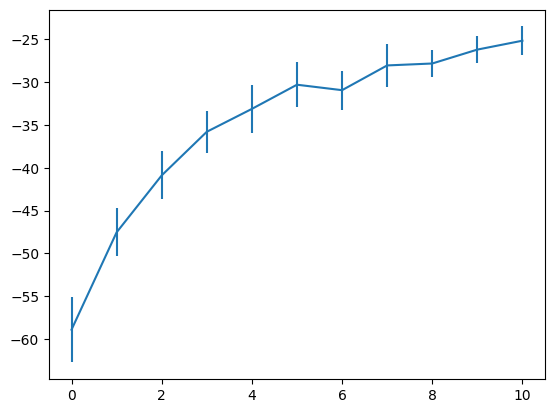

In [14]:
make_inference_fn, params, _ = train_fn(
    environment=env, progress_fn=progress, eval_env=eval_env
)

plt.errorbar(x_data, y_data, yerr=ydataerr)

""

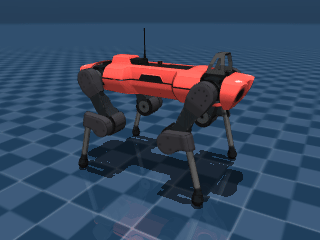

In [15]:
demo_env = envs.training.EpisodeWrapper(env, episode_length=1000, action_repeat=1)

render_rollout(
    jax.jit(demo_env.reset),
    jax.jit(demo_env.step),
    jax.jit(make_inference_fn(params)),
    demo_env,
    n_steps=200,
    seed=1,
)

model_path = "/tmp/trotting_2hz_policy"
model.save_params(model_path, params)

In [16]:
train_fn = functools.partial(
    ppo.train,
    num_timesteps=10_000_000,
    num_evals=10,
    reward_scaling=0.1,
    episode_length=1000,
    normalize_observations=True,
    action_repeat=1,
    unroll_length=10,
    num_minibatches=32,
    num_updates_per_batch=8,
    discounting=0.97,
    learning_rate=3e-4,
    entropy_cost=1e-3,
    num_envs=1024,
    batch_size=1024,
    seed=0,
)

x_data = []
y_data = []
ydataerr = []
env = envs.get_environment("trotting_anymal", step_k=13)


def progress(num_steps, metrics):
    x_data.append(num_steps)
    y_data.append(metrics["eval/episode_reward"])
    ydataerr.append(metrics["eval/episode_reward_std"])


make_inference_fn, params, _ = train_fn(environment=env, progress_fn=progress)

plt.errorbar(x_data, y_data, yerr=ydataerr)
plt.xlabel("# environment steps")
plt.ylabel("reward per episode")

/Users/wkm/Code/play/mindsim/.venv/lib/python3.11/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


Invalid nan value encountered in the output of a jax.jit function. Calling the de-optimized version.


FloatingPointError: Invalid value (nan) encountered in sharded computation.

In [18]:
def axis_angle_to_quaternion(v: jp.ndarray, theta: jp.float_):
    """
    axis angle representation: rotation of theta around v.
    """
    return jp.concatenate(
        [jp.cos(0.5 * theta).reshape(1), jp.sin(0.5 * theta) * v.reshape(3)]
    )


def get_config():
    """Returns reward config for anymal quadruped environment."""

    def get_default_rewards_config():
        default_config = config_dict.ConfigDict(
            dict(
                scales=config_dict.ConfigDict(
                    dict(
                        tracking_lin_vel=1.0,
                        orientation=-1.0,  # non-flat base
                        height=0.5,
                        lin_vel_z=-1.0,  # prevents the suicide policy
                        torque=-0.01,
                        feet_pos=-1,  # Bad action hard-coding.
                        feet_height=-1,  # prevents it from just standing still
                        joint_velocity=-0.001,
                    )
                ),
            )
        )
        return default_config

    default_config = config_dict.ConfigDict(
        dict(
            rewards=get_default_rewards_config(),
        )
    )

    return default_config


class FwdTrotAnymal(PipelineEnv):
    def __init__(
        self,
        termination_height: float = 0.25,
        **kwargs,
    ):
        self.target_vel = kwargs.pop("target_vel", 0.75)
        step_k = kwargs.pop("step_k", 25)
        self.baseline_inference_fn = kwargs.pop("baseline_inference_fn")
        physics_steps_per_control_step = 10
        kwargs["n_frames"] = kwargs.get("n_frames", physics_steps_per_control_step)
        self.termination_height = termination_height

        mj_model = mujoco.MjModel.from_xml_path(xml_path)
        kp = 230
        mj_model.actuator_gainprm[:, 0] = kp
        mj_model.actuator_biasprm[:, 1] = -kp
        self._init_q = mj_model.keyframe("standing").qpos
        self._default_ap_pose = mj_model.keyframe("standing").qpos[7:]
        self.reward_config = get_config()

        self.action_loc = self._default_ap_pose
        self.action_scale = jp.array([0.2, 0.8, 0.8] * 4)

        self.target_h = self._init_q[2]

        sys = mjcf.load_model(mj_model)
        super().__init__(sys=sys, **kwargs)

        """
    Kinematic references are used for gait scheduling.
    """

        kinematic_ref_qpos = make_kinematic_ref(cos_wave, step_k, scale=0.3, dt=self.dt)
        self.l_cycle = jp.array(kinematic_ref_qpos.shape[0])
        self.kinematic_ref_qpos = jp.array(kinematic_ref_qpos + self._default_ap_pose)

        """
    Foot tracking
    """
        gait_k = step_k * 2
        self.gait_period = gait_k * self.dt

        self.step_k = step_k
        self.feet_inds = jp.array([21, 28, 35, 42])  # LF, RF, LH, RH
        self.hip_inds = self.feet_inds - 6

        self.pipeline_step = jax.checkpoint(
            self.pipeline_step,
            policy=jax.checkpoint_policies.dots_with_no_batch_dims_saveable,
        )

    def reset(self, rng: jax.Array) -> State:
        rng, key_xyz, key_ang, key_ax, key_q, key_qd = jax.random.split(rng, 6)

        qpos = jp.array(self._init_q)
        qvel = jp.zeros(18)

        #### Add Randomness ####

        r_xyz = 0.2 * (jax.random.uniform(key_xyz, (3,)) - 0.5)
        r_angle = (jp.pi / 12) * (
            jax.random.uniform(key_ang, (1,)) - 0.5
        )  # 15 deg range
        r_axis = jax.random.uniform(key_ax, (3,)) - 0.5
        r_axis = r_axis / jp.linalg.norm(r_axis)
        r_quat = axis_angle_to_quaternion(r_axis, r_angle)

        r_joint_q = 0.2 * (jax.random.uniform(key_q, (12,)) - 0.5)
        r_joint_qd = 0.1 * (jax.random.uniform(key_qd, (12,)) - 0.5)

        qpos = qpos.at[0:3].set(qpos[0:3] + r_xyz)
        qpos = qpos.at[3:7].set(r_quat)
        qpos = qpos.at[7:19].set(qpos[7:19] + r_joint_q)
        qvel = qvel.at[6:18].set(qvel[6:18] + r_joint_qd)

        data = self.pipeline_init(qpos, qvel)

        # Ensure you're not sunken into the ground nor above it.
        pen = jp.min(data.contact.dist)
        qpos = qpos.at[2].set(qpos[2] - pen)
        data = self.pipeline_init(qpos, qvel)

        state_info = {
            "rng": rng,
            "steps": 0.0,
            "reward_tuple": {
                "tracking_lin_vel": 0.0,
                "orientation": 0.0,
                "height": 0.0,
                "lin_vel_z": 0.0,
                "torque": 0.0,
                "joint_velocity": 0.0,
                "feet_pos": 0.0,
                "feet_height": 0.0,
            },
            "last_action": jp.zeros(12),  # from MJX tutorial.
            "baseline_action": jp.zeros(12),
            "xy0": jp.zeros((4, 2)),
            "k0": 0.0,
            "xy*": jp.zeros((4, 2)),
        }

        x, xd = data.x, data.xd
        _obs = self._get_obs(data.qpos, x, xd, state_info)  # inner obs; to trotter

        action_key, key = jax.random.split(state_info["rng"])
        state_info["rng"] = key
        next_action, _ = self.baseline_inference_fn(_obs, action_key)

        obs = jp.concatenate([_obs, next_action])

        reward, done = jp.zeros(2)
        metrics = {}
        for k in state_info["reward_tuple"]:
            metrics[k] = state_info["reward_tuple"][k]
        state = State(data, obs, reward, done, metrics, state_info)
        return jax.lax.stop_gradient(state)

    def step(self, state: State, action: jax.Array) -> State:
        action = jp.clip(action, -1, 1)

        cur_base = state.obs[-12:]
        action += cur_base
        state.info["baseline_action"] = cur_base

        action = self.action_loc + (action * self.action_scale)

        data = self.pipeline_step(state.pipeline_state, action)

        # observation data
        x, xd = data.x, data.xd
        obs = self._get_obs(data.qpos, x, xd, state.info)

        # Terminate if flipped over or fallen down.
        done = 0.0
        done = jp.where(x.pos[0, 2] < self.termination_height, 1.0, done)
        up = jp.array([0.0, 0.0, 1.0])
        done = jp.where(jp.dot(math.rotate(up, x.rot[0]), up) < 0, 1.0, done)

        #### Foot Position Reference Updating ####

        # Detect the start of a new step
        s = state.info["steps"]
        step_num = s // (self.step_k)
        even_step = step_num % 2 == 0
        new_step = (s % self.step_k) == 0
        new_even_step = jp.logical_and(new_step, even_step)
        new_odd_step = jp.logical_and(new_step, jp.logical_not(even_step))

        # Apply railbert heuristic to calculate target foot position, after step
        hip_xy = data.geom_xpos[self.hip_inds][:, :2]  # 4 x 2
        v_body = data.qvel[0:2]
        step_period = self.gait_period / 2
        raibert_xy = hip_xy + (step_period / 2) * v_body

        # Update.
        cur_tars = state.info["xy*"]
        i_RFLH = jp.array([1, 2])
        i_LFRH = jp.array([0, 3])
        feet_xy = data.geom_xpos[self.feet_inds][:, :2]

        # With the trotting gait, we will move one pair of opposite legs,
        # and keep the other pair fixed in place.
        case_c1 = raibert_xy.at[i_LFRH].set(feet_xy[i_LFRH])
        case_c2 = raibert_xy.at[i_RFLH].set(feet_xy[i_RFLH])
        xy_tars = jp.where(new_even_step, case_c1, cur_tars)
        xy_tars = jp.where(new_odd_step, case_c2, xy_tars)
        state.info["xy*"] = xy_tars

        # Save timestep and location at start of step.
        state.info["k0"] = jp.where(new_step, state.info["steps"], state.info["k0"])
        state.info["xy0"] = jp.where(new_step, feet_xy, state.info["xy0"])

        # reward
        reward_tuple = {
            "tracking_lin_vel": (
                self._reward_tracking_lin_vel(jp.array([self.target_vel, 0, 0]), x, xd)
                * self.reward_config.rewards.scales.tracking_lin_vel
            ),
            "orientation": (
                self._reward_orientation(x)
                * self.reward_config.rewards.scales.orientation
            ),
            "lin_vel_z": (
                self._reward_lin_vel_z(xd) * self.reward_config.rewards.scales.lin_vel_z
            ),
            "height": (
                self._reward_height(data.qpos)
                * self.reward_config.rewards.scales.height
            ),
            "torque": (
                self._reward_action(data.qfrc_actuator)
                * self.reward_config.rewards.scales.torque
            ),
            "joint_velocity": (
                self._reward_joint_velocity(data.qvel)
                * self.reward_config.rewards.scales.joint_velocity
            ),
            "feet_pos": (
                self._reward_feet_pos(data, state)
                * self.reward_config.rewards.scales.feet_pos
            ),
            "feet_height": (
                self._reward_feet_height(data, state.info)
                * self.reward_config.rewards.scales.feet_height
            ),
        }

        reward = sum(reward_tuple.values())

        # state management
        state.info["reward_tuple"] = reward_tuple
        state.info["last_action"] = action

        for k in state.info["reward_tuple"].keys():
            state.metrics[k] = state.info["reward_tuple"][k]

        # next action
        action_key, key = jax.random.split(state.info["rng"])
        state.info["rng"] = key
        next_action, _ = self.baseline_inference_fn(obs, action_key)
        obs = jp.concatenate([obs, next_action])

        state = state.replace(pipeline_state=data, obs=obs, reward=reward, done=done)
        return state

    def _get_obs(
        self, qpos: jax.Array, x: Transform, xd: Motion, state_info: Dict[str, Any]
    ) -> jax.Array:
        inv_base_orientation = math.quat_inv(x.rot[0])
        local_rpyrate = math.rotate(xd.ang[0], inv_base_orientation)

        obs_list = []
        # yaw rate
        obs_list.append(jp.array([local_rpyrate[2]]) * 0.25)
        # projected gravity
        obs_list.append(math.rotate(jp.array([0.0, 0.0, -1.0]), inv_base_orientation))
        # motor angles
        angles = qpos[7:19]
        obs_list.append(angles - self._default_ap_pose)
        # last action
        obs_list.append(state_info["last_action"])
        # gait schedule
        kin_ref = self.kinematic_ref_qpos[
            jp.array(state_info["steps"] % self.l_cycle, int)
        ]
        obs_list.append(kin_ref)

        obs = jp.clip(jp.concatenate(obs_list), -100.0, 100.0)

        return obs

    # ------------ reward functions----------------
    def _reward_tracking_lin_vel(
        self, commands: jax.Array, x: Transform, xd: Motion
    ) -> jax.Array:
        # Tracking of linear velocity commands (xy axes)
        local_vel = math.rotate(xd.vel[0], math.quat_inv(x.rot[0]))
        lin_vel_error = jp.sum(jp.square(commands[:2] - local_vel[:2]))
        lin_vel_reward = jp.exp(-lin_vel_error)
        return lin_vel_reward

    def _reward_orientation(self, x: Transform) -> jax.Array:
        # Penalize non flat base orientation
        up = jp.array([0.0, 0.0, 1.0])
        rot_up = math.rotate(up, x.rot[0])
        return jp.sum(jp.square(rot_up[:2]))

    def _reward_lin_vel_z(self, xd: Motion) -> jax.Array:
        # Penalize z axis base linear velocity
        return jp.clip(jp.square(xd.vel[0, 2]), 0, 10)

    def _reward_joint_velocity(self, qvel):
        return jp.clip(jp.sqrt(jp.sum(jp.square(qvel[6:]))), 0, 100)

    def _reward_height(self, qpos) -> jax.Array:
        return jp.exp(
            -jp.abs(qpos[2] - self.target_h)
        )  # Not going to be > 1 meter tall.

    def _reward_action(self, action) -> jax.Array:
        return jp.sqrt(jp.sum(jp.square(action)))

    def _reward_feet_pos(self, data, state):
        dt = (state.info["steps"] - state.info["k0"]) * self.dt  # scalar
        step_period = self.gait_period / 2
        xyt = state.info["xy0"] + (state.info["xy*"] - state.info["xy0"]) * (
            dt / step_period
        )

        feet_pos = data.geom_xpos[self.feet_inds][:, :2]

        rews = jp.sum(jp.square(feet_pos - xyt), axis=1)
        rews = jp.clip(rews, 0, 10)
        return jp.sum(rews)

    def _reward_feet_height(self, data, state_info):
        """
        Feet height tracks rectified sine waves
        """
        h_tar = 0.1
        t = state_info["steps"] * self.dt
        offset = self.gait_period / 2
        ref1 = jp.sin((2 * jp.pi / self.gait_period) * t)  # RF and LH feet
        ref2 = jp.sin((2 * jp.pi / self.gait_period) * (t - offset))  # LF and RH

        ref1, ref2 = ref1 * h_tar, ref2 * h_tar
        h_tars = jp.array([ref2, ref1, ref1, ref2])
        h_tars = h_tars.clip(min=0, max=None) + 0.02  # offset height of feet.

        feet_height = data.geom_xpos[self.feet_inds][:, 2]
        errs = jp.clip(jp.square(feet_height - h_tars), 0, 10)
        return jp.sum(errs)


envs.register_environment("anymal", FwdTrotAnymal)

In [ ]:
# Reconstruct the trotting inference function
make_networks_factory = functools.partial(
    apg_networks.make_apg_networks, hidden_layer_sizes=(256, 128)
)

nets = make_networks_factory(
    observation_size=1,  # Observation_size argument doesn't matter since it's only used for param init.
    action_size=12,
    preprocess_observations_fn=running_statistics.normalize,
)

make_inference_fn = apg_networks.make_inference_fn(nets)

# Configure locomotion training
make_networks_factory = functools.partial(
    apg_networks.make_apg_networks, hidden_layer_sizes=(128, 64)
)

epochs = 499

train_fn = functools.partial(
    apg.train,
    episode_length=1000,
    policy_updates=epochs,
    horizon_length=32,
    num_envs=64,
    learning_rate=1.5e-4,
    schedule_decay=0.995,
    num_eval_envs=64,
    num_evals=10 + 1,
    use_float64=True,
    normalize_observations=True,
    network_factory=make_networks_factory,
)

model_path = "/tmp/trotting_2hz_policy"
params = model.load_params(model_path)
baseline_inference_fn = make_inference_fn(params)

env_kwargs = dict(
    target_vel=0.75, step_k=13, baseline_inference_fn=baseline_inference_fn
)

/Users/wkm/Code/play/mindsim/.venv/lib/python3.11/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(
/Users/wkm/Code/play/mindsim/.venv/lib/python3.11/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


<ErrorbarContainer object of 3 artists>

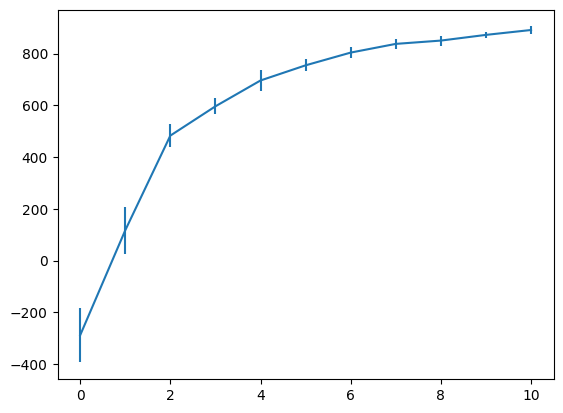

In [20]:
x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]


def progress(it, metrics):
    times.append(datetime.now())
    x_data.append(it)
    y_data.append(metrics["eval/episode_reward"])
    ydataerr.append(metrics["eval/episode_reward_std"])


env = envs.get_environment("anymal", **env_kwargs)
eval_env = envs.get_environment("anymal", **env_kwargs)

make_inference_fn, params, _ = train_fn(
    environment=env, progress_fn=progress, eval_env=eval_env
)

plt.errorbar(x_data, y_data, yerr=ydataerr)

""

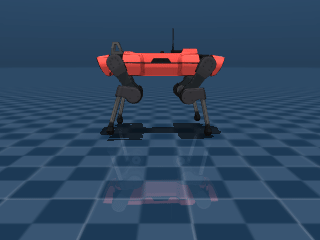

In [21]:
demo_env = envs.training.EpisodeWrapper(env, episode_length=1000, action_repeat=1)

render_rollout(
    jax.jit(demo_env.reset),
    jax.jit(demo_env.step),
    jax.jit(make_inference_fn(params)),
    demo_env,
    n_steps=200,
    camera="track",
)

In [22]:
train_fn = functools.partial(
    ppo.train,
    num_timesteps=10_000_000,
    num_evals=10,
    reward_scaling=0.1,
    episode_length=1000,
    normalize_observations=True,
    action_repeat=1,
    unroll_length=10,
    num_minibatches=32,
    num_updates_per_batch=8,
    discounting=0.97,
    learning_rate=3e-4,
    entropy_cost=1e-3,
    num_envs=1024,
    batch_size=1024,
    seed=0,
)

x_data = []
y_data = []
ydataerr = []

env = envs.get_environment("anymal", **env_kwargs)


def progress(num_steps, metrics):
    x_data.append(num_steps)
    y_data.append(metrics["eval/episode_reward"])
    ydataerr.append(metrics["eval/episode_reward_std"])


make_inference_fn, params, _ = train_fn(environment=env, progress_fn=progress)

plt.errorbar(x_data, y_data, yerr=ydataerr)
plt.xlabel("# environment steps")
plt.ylabel("reward per episode")

/Users/wkm/Code/play/mindsim/.venv/lib/python3.11/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


AssertionError: None